<a href="https://colab.research.google.com/github/alfredqbit/NU-DDS-8536/blob/main/sepulvedaADDS_8536_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4 — Bagging, Boosting, and Non-Classical Optimization

This notebook compares **Random Forest (bagging)**, **AdaBoost**, and **XGBoost** on the **Bank Marketing** dataset.  
It also implements two non-classical hyperparameter search strategies:

- **GA** (Genetic Algorithm)
- **QEA** (Quantum-inspired Evolutionary Algorithm)

> **Leakage note:** The `duration` field is excluded because it is only known after a call ends.


In [ ]:
import os, json, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, confusion_matrix
)

!pip install xgboost
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb


RANDOM_STATE = 42
MODEL_SAMPLE_SIZE = 12000   # to keep runtime manageable
MODEL_N_JOBS = 8

OUTDIR = "assignment4_outputs"
FIGDIR = os.path.join(OUTDIR, "figures")
os.makedirs(FIGDIR, exist_ok=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 MB 13.5 MB/s eta 0:00:00


In [ ]:

# --- Load dataset (download if needed) ---
DATA_PATH = "bank-additional-full.csv"

if not os.path.exists(DATA_PATH):
    import urllib.request
    url = "https://raw.githubusercontent.com/NikoletaEm/datasps/refs/heads/main/bank-additional-full.csv"
    urllib.request.urlretrieve(url, DATA_PATH)

df = pd.read_csv(DATA_PATH, sep=";")
df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Rows: 41188 Cols: 21


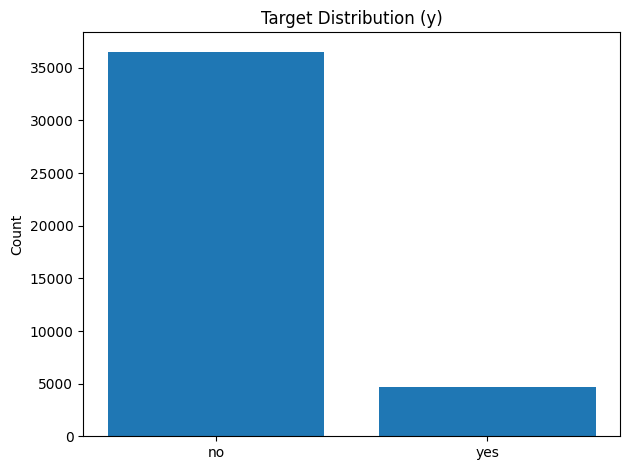

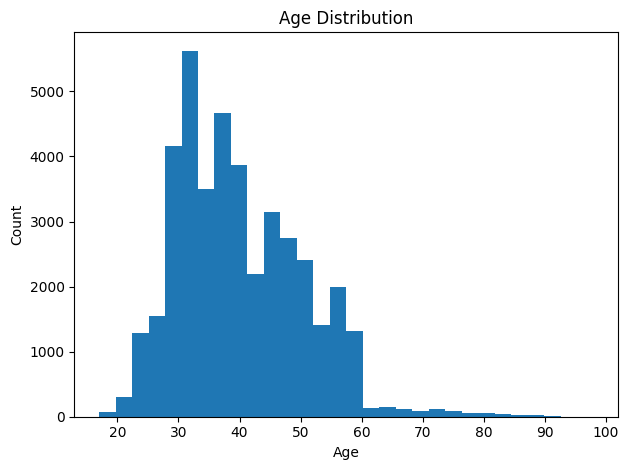

{'n_rows': 41188,
 'n_cols': 21,
 'target_counts': {'no': 36548, 'yes': 4640},
 'target_positive_rate': 0.11265417111780131,
 'dropped_feature': 'duration'}

In [ ]:

# --- Basic EDA ---
print("Rows:", df.shape[0], "Cols:", df.shape[1])

# Target distribution
counts = df["y"].value_counts()
plt.figure()
plt.bar(counts.index, counts.values)
plt.title("Target Distribution (y)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "eda_target_distribution.png"), dpi=200, bbox_inches="tight")
plt.show()

# Numeric example: age
plt.figure()
plt.hist(df["age"], bins=30)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "eda_age_hist.png"), dpi=200, bbox_inches="tight")
plt.show()

# Save dataset summary
summary = {
    "n_rows": int(df.shape[0]),
    "n_cols": int(df.shape[1]),
    "target_counts": counts.to_dict(),
    "target_positive_rate": float((df["y"]=="yes").mean()),
    "dropped_feature": "duration",
}
with open(os.path.join(OUTDIR, "dataset_summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

summary


In [ ]:

# --- Prepare modeling data (drop leakage feature) ---
X_full = df.drop(columns=["y", "duration"])
y_full = (df["y"]=="yes").astype(int)

# Stratified sample for speed
X_s, _, y_s, _ = train_test_split(
    X_full, y_full,
    train_size=MODEL_SAMPLE_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_full
)

# Train/Val/Test: 60/20/20 of the sample
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_s, y_s,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_s
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,  # 0.25 of 80% => 20%
    random_state=RANDOM_STATE,
    stratify=y_trainval
)

print("Sample size:", len(X_s))
print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))

# Preprocessing
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocessor = ColumnTransformer([
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
    ]), cat_cols),
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median"))
    ]), num_cols),
])

preprocessor


Sample size: 12000
Train: 7200 Val: 2400 Test: 2400


ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month',
                                  'day_of_week', 'poutcome']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['age', 'campaign', 'pdays', 'previous',
                                  'emp.var.rate', 'cons.price.idx',
                                  'cons.conf.idx', 'euribor3m',
                                  'nr.employed'])])

In [ ]:

# --- Random Forest tuning (small candidate set) ---
candidate_params = [
    {"n_estimators": 200, "max_depth": None, "max_features": "sqrt", "min_samples_leaf": 1},
    {"n_estimators": 400, "max_depth": None, "max_features": "sqrt", "min_samples_leaf": 1},
    {"n_estimators": 300, "max_depth": 12,   "max_features": "sqrt", "min_samples_leaf": 1},
    {"n_estimators": 300, "max_depth": 20,   "max_features": "sqrt", "min_samples_leaf": 1},
    {"n_estimators": 300, "max_depth": 12,   "max_features": 0.5,    "min_samples_leaf": 1},
    {"n_estimators": 300, "max_depth": 12,   "max_features": 0.3,    "min_samples_leaf": 1},
    {"n_estimators": 400, "max_depth": 20,   "max_features": 0.5,    "min_samples_leaf": 2},
    {"n_estimators": 500, "max_depth": 20,   "max_features": 0.5,    "min_samples_leaf": 3},
]

rows=[]
best=None
for params in candidate_params:
    model = RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=MODEL_N_JOBS,
        class_weight="balanced",
        **params
    )
    pipe = Pipeline([("preprocess", preprocessor), ("model", model)])
    t0 = time.perf_counter()
    pipe.fit(X_train, y_train)
    fit_time = time.perf_counter() - t0
    y_val_score = pipe.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_val_score)
    row = {**params, "val_roc_auc": auc, "fit_time_sec": fit_time}
    rows.append(row)
    if (best is None) or (auc > best["val_roc_auc"]):
        best = row

rf_tune = pd.DataFrame(rows).sort_values("val_roc_auc", ascending=False)
rf_tune


,n_estimators,max_depth,max_features,min_samples_leaf,val_roc_auc,fit_time_sec
7,500,20.0,0.5,3,0.794212,0.982045
6,400,20.0,0.5,2,0.792796,0.794181
1,400,NaN,sqrt,1,0.786990,0.579068
0,200,NaN,sqrt,1,0.786870,0.307771
2,300,12.0,sqrt,1,0.786694,0.402448
5,300,12.0,0.3,1,0.786382,0.471871
3,300,20.0,sqrt,1,0.785869,0.448103
4,300,12.0,0.5,1,0.777478,0.568159


In [ ]:

rf_tune.to_csv(os.path.join(OUTDIR, "rf_tuning_results.csv"), index=False)
with open(os.path.join(OUTDIR, "rf_best_params.json"), "w") as f:
    json.dump(best, f, indent=2)
best


{'n_estimators': 500,
 'max_depth': 20,
 'max_features': 0.5,
 'min_samples_leaf': 3,
 'val_roc_auc': np.float64(0.7942123109024517),
 'fit_time_sec': 0.9820453659999657}

In [ ]:

# --- AdaBoost tuning ---
candidate_params = [
    {"n_estimators": 100, "learning_rate": 0.05, "max_depth": 1},
    {"n_estimators": 200, "learning_rate": 0.05, "max_depth": 1},
    {"n_estimators": 400, "learning_rate": 0.05, "max_depth": 1},
    {"n_estimators": 200, "learning_rate": 0.1,  "max_depth": 1},
    {"n_estimators": 400, "learning_rate": 0.1,  "max_depth": 1},
    {"n_estimators": 200, "learning_rate": 0.2,  "max_depth": 1},
    {"n_estimators": 400, "learning_rate": 0.2,  "max_depth": 1},
    {"n_estimators": 200, "learning_rate": 0.1,  "max_depth": 2},
    {"n_estimators": 400, "learning_rate": 0.1,  "max_depth": 2},
]

rows=[]
best=None
for params in candidate_params:
    base = DecisionTreeClassifier(max_depth=params["max_depth"], random_state=RANDOM_STATE)
    model = AdaBoostClassifier(
        estimator=base,
        n_estimators=params["n_estimators"],
        learning_rate=params["learning_rate"],
        random_state=RANDOM_STATE
    )
    pipe = Pipeline([("preprocess", preprocessor), ("model", model)])
    t0 = time.perf_counter()
    pipe.fit(X_train, y_train)
    fit_time = time.perf_counter() - t0
    y_val_score = pipe.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_val_score)
    row = {**params, "val_roc_auc": auc, "fit_time_sec": fit_time}
    rows.append(row)
    if (best is None) or (auc > best["val_roc_auc"]):
        best = row

ada_tune = pd.DataFrame(rows).sort_values("val_roc_auc", ascending=False)
ada_tune


,n_estimators,learning_rate,max_depth,val_roc_auc,fit_time_sec
8,400,0.10,2,0.788708,3.293351
7,200,0.10,2,0.788020,1.668454
4,400,0.10,1,0.779883,2.127414
2,400,0.05,1,0.779744,2.121844
3,200,0.10,1,0.779477,1.078316
5,200,0.20,1,0.779298,1.072319
1,200,0.05,1,0.779201,1.080406
6,400,0.20,1,0.779094,2.120603
0,100,0.05,1,0.777404,0.558281


In [ ]:

ada_tune.to_csv(os.path.join(OUTDIR, "adaboost_tuning_results.csv"), index=False)
with open(os.path.join(OUTDIR, "adaboost_best_params.json"), "w") as f:
    json.dump(best, f, indent=2)
best


{'n_estimators': 400,
 'learning_rate': 0.1,
 'max_depth': 2,
 'val_roc_auc': np.float64(0.7887080507737784),
 'fit_time_sec': 3.2933514540000033}

In [ ]:

# --- XGBoost tuning (small candidate set) ---
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

candidate_params = [
    {"n_estimators": 200, "max_depth": 3, "learning_rate": 0.05, "subsample": 0.8, "colsample_bytree": 0.8, "reg_lambda": 1.0},
    {"n_estimators": 300, "max_depth": 3, "learning_rate": 0.05, "subsample": 0.8, "colsample_bytree": 0.8, "reg_lambda": 1.0},
    {"n_estimators": 200, "max_depth": 4, "learning_rate": 0.05, "subsample": 0.8, "colsample_bytree": 0.8, "reg_lambda": 1.0},
    {"n_estimators": 300, "max_depth": 4, "learning_rate": 0.05, "subsample": 0.8, "colsample_bytree": 0.8, "reg_lambda": 1.0},
    {"n_estimators": 200, "max_depth": 3, "learning_rate": 0.1,  "subsample": 0.8, "colsample_bytree": 0.8, "reg_lambda": 1.0},
    {"n_estimators": 300, "max_depth": 3, "learning_rate": 0.1,  "subsample": 0.8, "colsample_bytree": 0.8, "reg_lambda": 1.0},
    {"n_estimators": 300, "max_depth": 4, "learning_rate": 0.1,  "subsample": 0.9, "colsample_bytree": 0.9, "reg_lambda": 5.0},
]

rows=[]
best=None
for params in candidate_params:
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        tree_method="hist",
        n_jobs=MODEL_N_JOBS,
        scale_pos_weight=scale_pos_weight,
        **params
    )
    pipe = Pipeline([("preprocess", preprocessor), ("model", model)])
    t0 = time.perf_counter()
    pipe.fit(X_train, y_train)
    fit_time = time.perf_counter() - t0
    y_val_score = pipe.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_val_score)
    row = {**params, "val_roc_auc": auc, "fit_time_sec": fit_time}
    rows.append(row)
    if (best is None) or (auc > best["val_roc_auc"]):
        best = row

xgb_tune = pd.DataFrame(rows).sort_values("val_roc_auc", ascending=False)
xgb_tune


,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,reg_lambda,val_roc_auc,fit_time_sec
0,200,3,0.05,0.8,0.8,1.0,0.799838,0.089404
1,300,3,0.05,0.8,0.8,1.0,0.798919,0.120034
4,200,3,0.10,0.8,0.8,1.0,0.796587,0.090087
2,200,4,0.05,0.8,0.8,1.0,0.794895,0.107455
3,300,4,0.05,0.8,0.8,1.0,0.790488,0.146060
5,300,3,0.10,0.8,0.8,1.0,0.784718,0.150002
6,300,4,0.10,0.9,0.9,5.0,0.777751,0.145559


In [ ]:

xgb_tune.to_csv(os.path.join(OUTDIR, "xgboost_tuning_results.csv"), index=False)
with open(os.path.join(OUTDIR, "xgboost_best_params.json"), "w") as f:
    json.dump(best, f, indent=2)
best


{'n_estimators': 200,
 'max_depth': 3,
 'learning_rate': 0.05,
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'reg_lambda': 1.0,
 'val_roc_auc': np.float64(0.7998382889932185),
 'fit_time_sec': 0.08940425100013272}

In [ ]:

# --- Genetic Algorithm (GA) hyperparameter search for XGBoost ---
# We tune on smaller subsets to keep runtime bounded.
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train, y_train, train_size=2000, random_state=RANDOM_STATE, stratify=y_train
)
X_val_sub, _, y_val_sub, _ = train_test_split(
    X_val, y_val, train_size=800, random_state=RANDOM_STATE, stratify=y_val
)
scale_pos_weight_sub = (len(y_train_sub) - y_train_sub.sum()) / y_train_sub.sum()

# Discrete options (2 bits each => 10-bit chromosome)
n_estimators_opts = [100, 150, 200, 250]
max_depth_opts = [3, 4, 5, 6]
learning_rate_opts = [0.05, 0.10, 0.15, 0.20]
subsample_opts = [0.7, 0.8, 0.9, 1.0]
colsample_opts = [0.7, 0.8, 0.9, 1.0]

def decode(bits):
    bits = list(map(int, bits))
    def b2i(b): return (b[0]<<1) | b[1]
    return {
        "n_estimators": n_estimators_opts[b2i(bits[0:2])],
        "max_depth": max_depth_opts[b2i(bits[2:4])],
        "learning_rate": learning_rate_opts[b2i(bits[4:6])],
        "subsample": subsample_opts[b2i(bits[6:8])],
        "colsample_bytree": colsample_opts[b2i(bits[8:10])],
    }

def fitness(bits):
    params = decode(bits)
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        tree_method="hist",
        n_jobs=MODEL_N_JOBS,
        scale_pos_weight=scale_pos_weight_sub,
        reg_lambda=1.0,
        **params
    )
    pipe = Pipeline([("preprocess", preprocessor), ("model", model)])
    pipe.fit(X_train_sub, y_train_sub)
    y_score = pipe.predict_proba(X_val_sub)[:,1]
    return roc_auc_score(y_val_sub, y_score)

rng = np.random.default_rng(RANDOM_STATE)

def ga_optimize(pop_size=5, generations=2, cx_prob=0.8, mut_prob=0.1):
    pop = rng.integers(0,2,size=(pop_size,10))
    scores = np.array([fitness(ind) for ind in pop])
    best_idx = int(np.argmax(scores))
    best_bits = pop[best_idx].copy()
    best_score = float(scores[best_idx])

    def tournament(k=3):
        idx = rng.choice(pop_size, size=k, replace=True)
        return pop[idx[np.argmax(scores[idx])]].copy()

    def crossover(a,b):
        if rng.random() < cx_prob:
            p = rng.integers(1,len(a))
            c1 = np.concatenate([a[:p], b[p:]])
            c2 = np.concatenate([b[:p], a[p:]])
            return c1,c2
        return a.copy(), b.copy()

    def mutate(ind):
        mask = rng.random(len(ind)) < mut_prob
        ind[mask] = 1 - ind[mask]
        return ind

    for _ in range(generations):
        new_pop = [best_bits.copy()]  # elitism
        while len(new_pop) < pop_size:
            p1,p2 = tournament(), tournament()
            c1,c2 = crossover(p1,p2)
            new_pop.append(mutate(c1))
            if len(new_pop) < pop_size:
                new_pop.append(mutate(c2))
        pop = np.array(new_pop)
        scores = np.array([fitness(ind) for ind in pop])
        gen_best = int(np.argmax(scores))
        if float(scores[gen_best]) > best_score:
            best_score = float(scores[gen_best])
            best_bits = pop[gen_best].copy()

    return best_bits, best_score

t0 = time.perf_counter()
best_bits, best_auc = ga_optimize()
ga_time = time.perf_counter() - t0
ga_best = {"best_params": decode(best_bits), "val_roc_auc": float(best_auc), "tuning_time_sec": float(ga_time)}
ga_best


{'best_params': {'n_estimators': 150,
  'max_depth': 5,
  'learning_rate': 0.1,
  'subsample': 0.8,
  'colsample_bytree': 0.7},
 'val_roc_auc': 0.77302034428795,
 'tuning_time_sec': 1.1665244280000024}

In [ ]:

with open(os.path.join(OUTDIR, "ga_xgboost_best_params.json"), "w") as f:
    json.dump({
        **ga_best,
        "search_space": {"n_estimators": n_estimators_opts, "max_depth": max_depth_opts, "learning_rate": learning_rate_opts,
                         "subsample": subsample_opts, "colsample_bytree": colsample_opts},
        "tuning_subset_sizes": {"train": int(len(X_train_sub)), "val": int(len(X_val_sub))}
    }, f, indent=2)


In [ ]:

# --- Quantum-inspired Evolutionary Algorithm (QEA) hyperparameter search for XGBoost ---
def qea_optimize(pop_size=6, generations=4, delta=0.18):
    theta = np.full(10, math.pi/4)  # p(bit=1)=sin^2(theta)
    best_bits = None
    best_score = -np.inf

    for _ in range(generations):
        probs = np.sin(theta)**2
        pop = (rng.random((pop_size,10)) < probs).astype(int)
        scores = np.array([fitness(ind) for ind in pop])
        idx = int(np.argmax(scores))
        if float(scores[idx]) > best_score:
            best_score = float(scores[idx])
            best_bits = pop[idx].copy()

        # rotate toward best_bits
        for i in range(10):
            if best_bits[i] == 1:
                theta[i] = min(theta[i] + delta, math.pi/2)
            else:
                theta[i] = max(theta[i] - delta, 0.0)

    return best_bits, best_score

t0 = time.perf_counter()
best_bits, best_auc = qea_optimize()
qea_time = time.perf_counter() - t0
qea_best = {"best_params": decode(best_bits), "val_roc_auc": float(best_auc), "tuning_time_sec": float(qea_time)}
qea_best


{'best_params': {'n_estimators': 100,
  'max_depth': 4,
  'learning_rate': 0.15,
  'subsample': 0.8,
  'colsample_bytree': 0.8},
 'val_roc_auc': 0.7755242566510172,
 'tuning_time_sec': 1.700926736999918}

In [ ]:

with open(os.path.join(OUTDIR, "qea_xgboost_best_params.json"), "w") as f:
    json.dump({
        **qea_best,
        "search_space": {"n_estimators": n_estimators_opts, "max_depth": max_depth_opts, "learning_rate": learning_rate_opts,
                         "subsample": subsample_opts, "colsample_bytree": colsample_opts},
        "tuning_subset_sizes": {"train": int(len(X_train_sub)), "val": int(len(X_val_sub))}
    }, f, indent=2)


In [ ]:

# --- Final training (train+val) and test evaluation ---
# Compute scale_pos_weight on trainval
scale_pos_weight_tv = (len(y_trainval) - y_trainval.sum()) / y_trainval.sum()

# Load best params from jsons produced above
with open(os.path.join(OUTDIR, "rf_best_params.json")) as f:
    rf_best = json.load(f)
with open(os.path.join(OUTDIR, "adaboost_best_params.json")) as f:
    ada_best = json.load(f)
with open(os.path.join(OUTDIR, "xgboost_best_params.json")) as f:
    xgb_best = json.load(f)
with open(os.path.join(OUTDIR, "ga_xgboost_best_params.json")) as f:
    ga_best = json.load(f)["best_params"]
with open(os.path.join(OUTDIR, "qea_xgboost_best_params.json")) as f:
    qea_best = json.load(f)["best_params"]

def eval_model(name, pipe):
    t0 = time.perf_counter()
    pipe.fit(X_trainval, y_trainval)
    fit_time = time.perf_counter() - t0

    t0 = time.perf_counter()
    y_pred = pipe.predict(X_test)
    y_score = pipe.predict_proba(X_test)[:,1]
    pred_time = time.perf_counter() - t0

    cm = confusion_matrix(y_test, y_pred)
    metrics = {
        "model": name,
        "roc_auc": roc_auc_score(y_test, y_score),
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "fit_time_sec": fit_time,
        "predict_time_sec": pred_time,
        "tn": int(cm[0,0]), "fp": int(cm[0,1]), "fn": int(cm[1,0]), "tp": int(cm[1,1])
    }
    return metrics, y_score, y_pred

results = []
scores = {}
preds = {}

rf_model = RandomForestClassifier(
    random_state=RANDOM_STATE, n_jobs=MODEL_N_JOBS, class_weight="balanced",
    n_estimators=rf_best["n_estimators"],
    max_depth=rf_best["max_depth"],
    max_features=rf_best["max_features"],
    min_samples_leaf=rf_best["min_samples_leaf"]
)
rf_pipe = Pipeline([("preprocess", preprocessor), ("model", rf_model)])
m, s, p = eval_model("Random Forest", rf_pipe)
results.append(m); scores["Random Forest"]=s; preds["Random Forest"]=p

ada_base = DecisionTreeClassifier(max_depth=int(ada_best["max_depth"]), random_state=RANDOM_STATE)
ada_model = AdaBoostClassifier(
    estimator=ada_base,
    n_estimators=int(ada_best["n_estimators"]),
    learning_rate=float(ada_best["learning_rate"]),
    random_state=RANDOM_STATE
)
ada_pipe = Pipeline([("preprocess", preprocessor), ("model", ada_model)])
m, s, p = eval_model("AdaBoost", ada_pipe)
results.append(m); scores["AdaBoost"]=s; preds["AdaBoost"]=p

xgb_model = xgb.XGBClassifier(
    objective="binary:logistic", eval_metric="logloss", random_state=RANDOM_STATE,
    tree_method="hist", n_jobs=MODEL_N_JOBS,
    scale_pos_weight=scale_pos_weight_tv,
    n_estimators=xgb_best["n_estimators"],
    max_depth=xgb_best["max_depth"],
    learning_rate=xgb_best["learning_rate"],
    subsample=xgb_best["subsample"],
    colsample_bytree=xgb_best["colsample_bytree"],
    reg_lambda=xgb_best["reg_lambda"]
)
xgb_pipe = Pipeline([("preprocess", preprocessor), ("model", xgb_model)])
m, s, p = eval_model("XGBoost", xgb_pipe)
results.append(m); scores["XGBoost"]=s; preds["XGBoost"]=p

ga_model = xgb.XGBClassifier(
    objective="binary:logistic", eval_metric="logloss", random_state=RANDOM_STATE,
    tree_method="hist", n_jobs=MODEL_N_JOBS,
    scale_pos_weight=scale_pos_weight_tv,
    reg_lambda=1.0,
    **ga_best
)
ga_pipe = Pipeline([("preprocess", preprocessor), ("model", ga_model)])
m, s, p = eval_model("GA-XGBoost", ga_pipe)
results.append(m); scores["GA-XGBoost"]=s; preds["GA-XGBoost"]=p

qea_model = xgb.XGBClassifier(
    objective="binary:logistic", eval_metric="logloss", random_state=RANDOM_STATE,
    tree_method="hist", n_jobs=MODEL_N_JOBS,
    scale_pos_weight=scale_pos_weight_tv,
    reg_lambda=1.0,
    **qea_best
)
qea_pipe = Pipeline([("preprocess", preprocessor), ("model", qea_model)])
m, s, p = eval_model("QEA-XGBoost", qea_pipe)
results.append(m); scores["QEA-XGBoost"]=s; preds["QEA-XGBoost"]=p

metrics_df = pd.DataFrame(results).sort_values("roc_auc", ascending=False)
metrics_df.to_csv(os.path.join(OUTDIR, "final_metrics.csv"), index=False)
metrics_df


,model,roc_auc,accuracy,precision,recall,f1,fit_time_sec,predict_time_sec,tn,fp,fn,tp
0,Random Forest,0.786886,0.891250,0.518987,0.455556,0.485207,1.223497,0.184221,2016,114,147,123
1,AdaBoost,0.779158,0.904167,0.770270,0.211111,0.331395,4.349715,0.153750,2113,17,213,57
2,XGBoost,0.777887,0.843333,0.381166,0.629630,0.474860,0.101758,0.016063,1854,276,100,170
3,GA-XGBoost,0.771135,0.847083,0.381995,0.581481,0.461087,0.116203,0.016787,1876,254,113,157
4,QEA-XGBoost,0.767757,0.842083,0.377528,0.622222,0.469930,0.082908,0.016144,1853,277,102,168


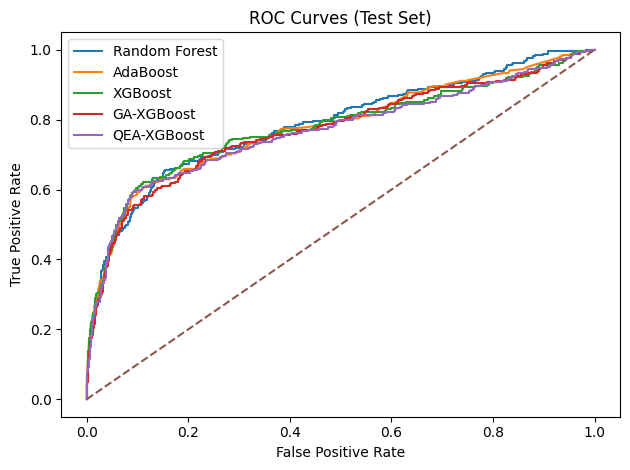

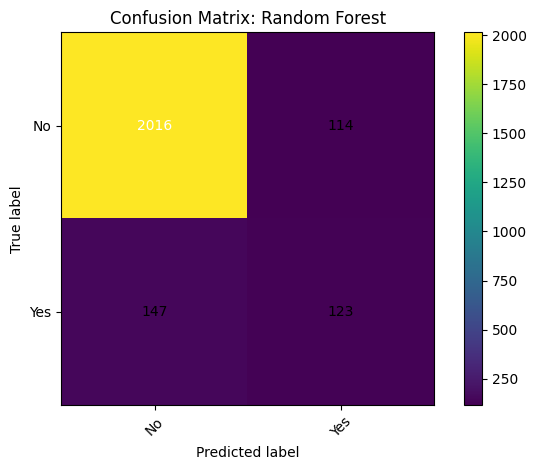

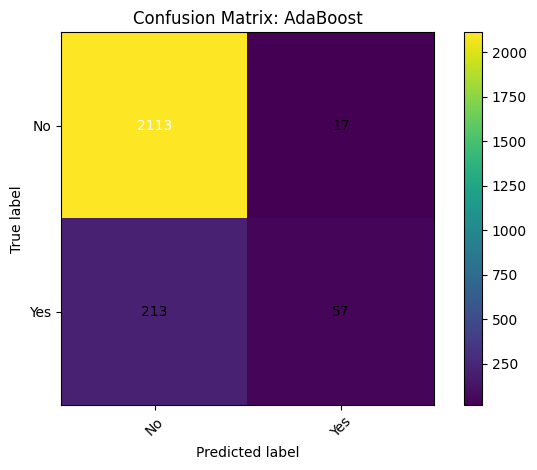

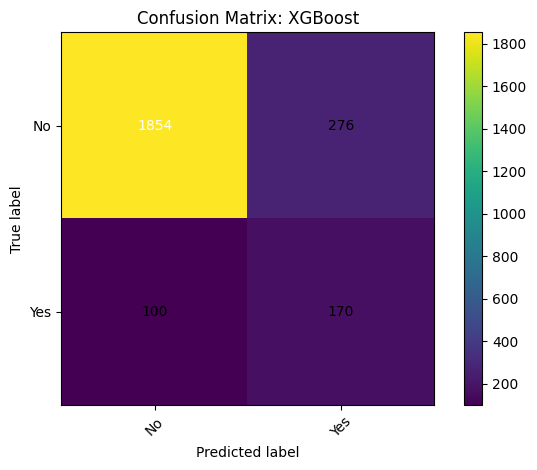

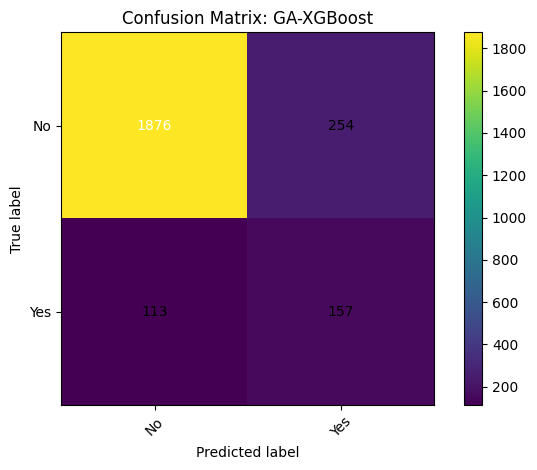

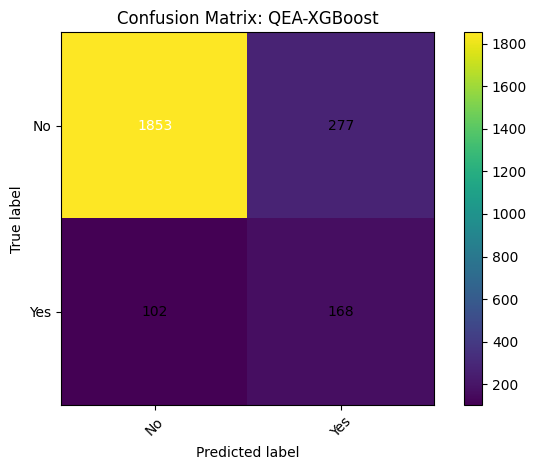

In [ ]:

# --- ROC curves ---
plt.figure()
for name, y_score in scores.items():
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1], linestyle="--")
plt.title("ROC Curves (Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "roc_curves_all.png"), dpi=200, bbox_inches="tight")
plt.show()

# --- Confusion matrices ---
for name, y_pred in preds.items():
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix: {name}")
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ["No", "Yes"], rotation=45)
    plt.yticks(ticks, ["No", "Yes"])
    thresh = cm.max()/2
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i,j]),
                     ha="center", va="center",
                     color="white" if cm[i,j] > thresh else "black")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.savefig(os.path.join(FIGDIR, f"confusion_{name.replace(' ','_').lower()}.png"), dpi=200, bbox_inches="tight")
    plt.show()


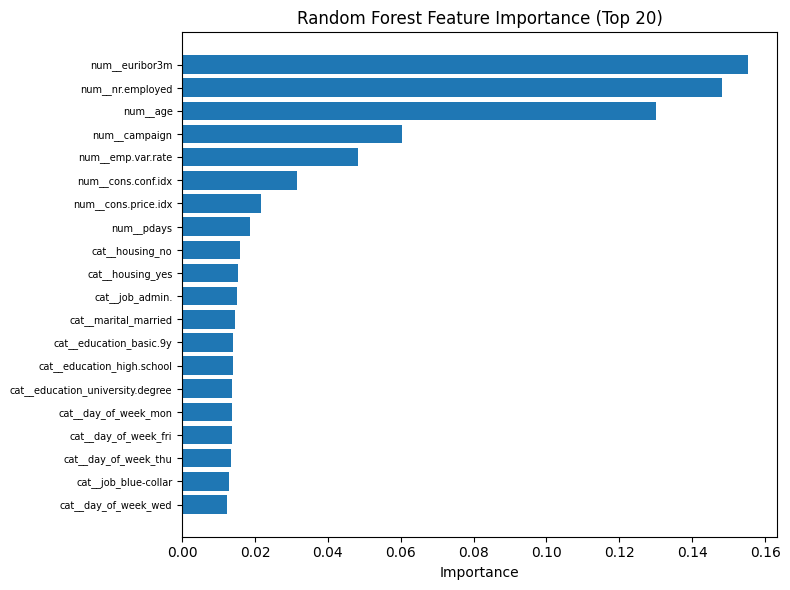

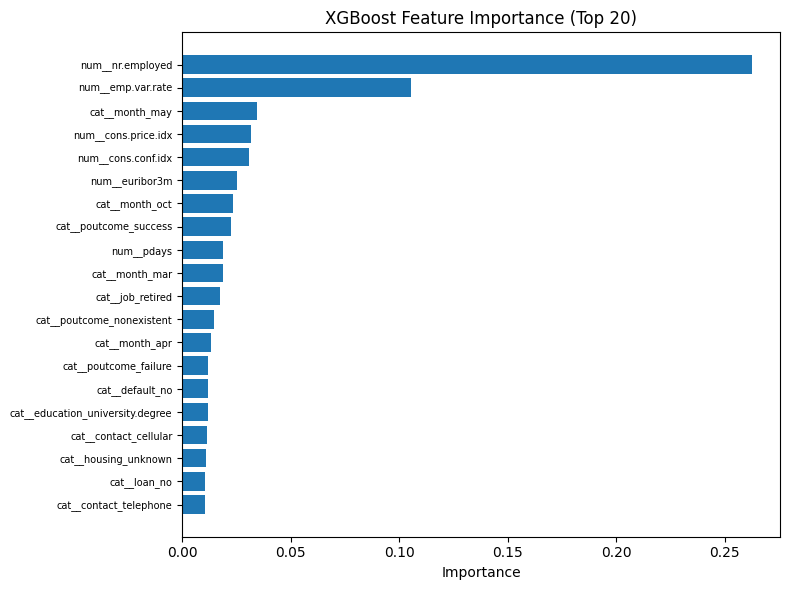

In [ ]:

# --- Feature importance (Random Forest and XGBoost) ---
# Fit on trainval for feature importance extraction
rf_pipe.fit(X_trainval, y_trainval)
xgb_pipe.fit(X_trainval, y_trainval)

feature_names = rf_pipe.named_steps["preprocess"].get_feature_names_out()

def plot_top(importances, title, filename, top_n=20):
    idx = np.argsort(importances)[::-1][:top_n]
    labels = [feature_names[i] for i in idx][::-1]
    vals = importances[idx][::-1]
    plt.figure(figsize=(8,6))
    y_pos = np.arange(len(idx))
    plt.barh(y_pos, vals)
    plt.yticks(y_pos, labels, fontsize=7)
    plt.xlabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGDIR, filename), dpi=200, bbox_inches="tight")
    plt.show()

plot_top(rf_pipe.named_steps["model"].feature_importances_,
         "Random Forest Feature Importance (Top 20)",
         "feature_importance_random_forest.png")

plot_top(xgb_pipe.named_steps["model"].feature_importances_,
         "XGBoost Feature Importance (Top 20)",
         "feature_importance_xgboost.png")
